In [1]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);


path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";

os.chdir(path);
from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/Eigen Face";
os.chdir(path);


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#plt.style.use("seaborn-ticks")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
## convert the dataframe into np.array
df = pd.read_csv('face_data.csv');
X = df.drop('target', axis=1);
X = X.values;
y = df['target'];
y = y.values;

r = 64;
c = 64;

In [3]:
## check the eigen_value and eigen vector
def Check_Eigen(X):
    X_mean = np.mean(X, axis = 0);
    X_centered = X - X_mean;
    S = X_centered.T.dot(X_centered) / (len(X_centered)-1);
    eigen_val, eigen_vec = np.linalg.eig(S);
    '''
    r,c = X.shape;
    n_comp = min(r,c);
    eigen_vec = eigen_vec[:,:n_comp];
    '''
    return eigen_val, eigen_vec, X_mean;
    

X_train, X_test, y_train, y_test = train_test_split(X, y);
pca = PCA().fit(X_train);
#eigen_val, eigen_vec, X_train_mean = Check_Eigen(X_train);
eigen_val, eigen_vec, X_train_mean = pca.explained_variance_, pca.components_.T, pca.mean_

print(eigen_val.shape)
print(eigen_vec.shape)

(300,)
(4096, 300)


In [4]:
class Strategy(object):
    def __init__(self):
        self.prop = {};

    def add_item(self, name, item):
        if name not in self.prop:
            self.prop[name] = item;
        else:
            print("Item name already exists.");
    
    def rm_item(self, name):
        if name in self.prop:
            del self.prop[name];
        else:
            print("Item name doesn't exist.")

def get_greatest(eigen_val, threshold = 0.1): ## eigen values are sorted!
    for i in range(len(eigen_val)):
        if eigen_val[i] < eigen_val[0] * 0.1:
            Break;
    return i;

In [5]:
time_list = [60.];
compression_rate = 0.25;
cycles = int(compression_rate * r * c);
CS = Strategy();

random_mask = np.round(np.random.rand(cycles, (r*c)));
unit_mask = np.eye((r*c));

CS.add_item("phi", random_mask);

CS.add_item("cycles", len(CS.prop['phi'][:,0]));

CS.add_item("psi", eigen_vec.astype(float));
CS.add_item("n_photon", 1e6);
CS.add_item("measure", []);
CS.add_item("recons",[]);
CS.add_item("error", []);
CS.add_item("time_list", time_list);

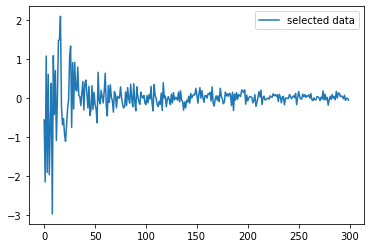

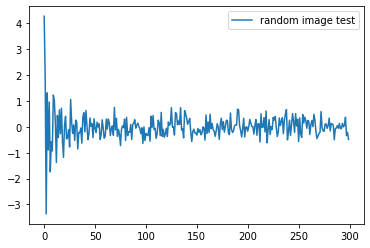

In [6]:
select = np.random.randint(len(y_test));
X_select = X_test[select]
y_select = y_test[select];

CS.add_item("data", X_select);

CS.add_item("true_coef", (CS.prop['data'] - X_train_mean).dot(CS.prop['psi']));

CS.add_item("recon_coef", []);

plt.figure(facecolor='w');
plt.plot(CS.prop['true_coef'], label = 'selected data');
plt.legend();
plt.show();

plt.figure(facecolor='w');
plt.plot((np.random.random(CS.prop['data'].shape) - X_train_mean).dot(CS.prop['psi']), label = 'random image test');
plt.legend();
plt.show();

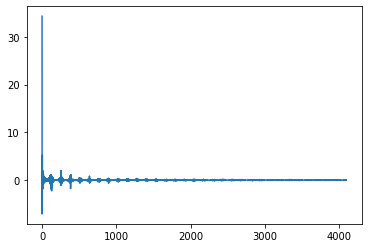

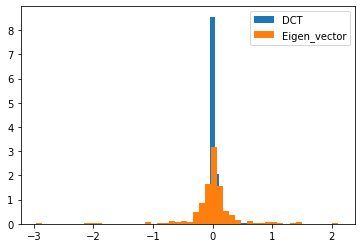

In [7]:
pmt = CSP();
pmt.img = CS.prop['data'].reshape(r,c);
pmt.img_tensor = np.array([pmt.img]).transpose(1,2,0);

dct_mtx = pmt.DCT_Matrix(r*c);
plt.figure(facecolor='w');
plt.plot(CS.prop['data'].dot(dct_mtx));
plt.show();

plt.figure(facecolor='w');
plt.hist((CS.prop['data']-X_train_mean).dot(dct_mtx), bins = 50, density = True, label = 'DCT');
plt.hist(CS.prop['true_coef'], bins= 50, density = True, label = 'Eigen_vector');
plt.legend();
plt.show();

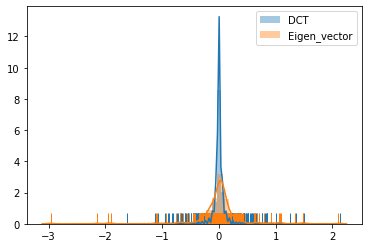

In [8]:
import seaborn as sns
plt.figure(facecolor='w');

sns.distplot((CS.prop['data']-X_train_mean).dot(dct_mtx), rug=True, label = 'DCT');
sns.distplot(CS.prop['true_coef'], rug=True, label = "Eigen_vector");

plt.legend();


In [9]:
Obj = CS;
time_list = Obj.prop['time_list'];
## start measurement!
Obj.prop['measure'] = [];
Obj.prop['error'] = [];
Obj.prop['recons'] = [];
Obj.prop['recon_coef'] = [];

Poisson = False;
phi = Obj.prop['phi'];
psi = Obj.prop['psi'];

#psi = dct_mtx;
#m = psi;
#phi = np.ceil(m / (2 * np.max(abs(m))))[:Obj.prop['cycles'],:];

psi = psi[:,:300]; ## 因为pca只能取样本数和特征数中最小的值

for time in time_list:
    light_level = Obj.prop['n_photon'] * time / (r*c) / Obj.prop['cycles'];
    measure = phi.dot(Obj.prop['data'].T);

    if Poisson:
        measure = np.random.poisson(measure * light_level) / light_level;

    measure -= phi.dot(X_train_mean);

    Obj.prop['measure'].append(measure);




0 / 1
Mini-batch (size 10) Gradient Ascent!

{cost = 3.412e+02} |··················································| 0.0%
{cost = 1.452e+00} |>>>>>>>>>>········································| 20.0%
{cost = 1.430e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.461e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.654e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.438e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

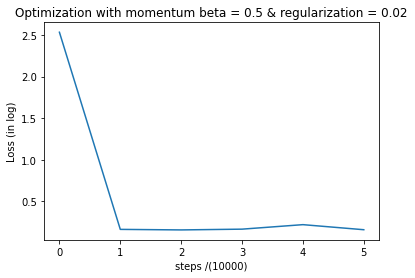

In [10]:


regu = 2e-2

for time_index in range(len(time_list)):
    print(time_index, '/', len(time_list));
    measure = Obj.prop['measure'][time_index];
    #measure = np.array(measure).reshape(-1,1);
    measure = np.array(measure).reshape(measure.shape[0],-1);
    pmt.PMT_reconstruct(r_tot = r, c_tot = c, measurement = measure, 
                        upload_DMD_basis = phi, upload_phi= psi, 
                        user_evaluation = False, learning_rate = 2e-3, 
                        regularization = regu, plot_step= 10000, max_epoch = 50000, display = False); 
                        ## It should be upload_psi，是一个笔误

    Obj.prop['recons'].append(pmt.img_reconstructed_vector + X_train_mean.reshape(-1,1));
    Obj.prop['recon_coef'].append(pmt.W);
    
    this_error = (np.mean((Obj.prop['recons'][-1] - Obj.prop['data'])**2));   
    Obj.prop['error'].append(this_error); 

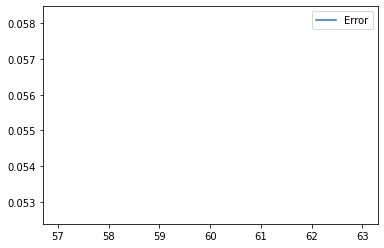

In [11]:
plt.figure(facecolor='w');
plt.plot(time_list, Obj.prop['error'], label = 'Error');
plt.legend();
plt.show();

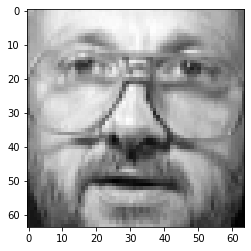

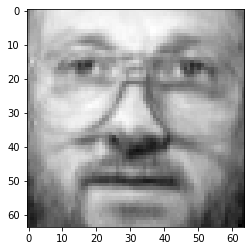

In [12]:
plt.figure(facecolor='w');
plt.imshow(Obj.prop['data'].reshape(r,c), cmap='gray');
plt.show();

plt.figure(facecolor='w');
plt.imshow(Obj.prop['recons'][-1].reshape(r,c), cmap='gray');
plt.show();

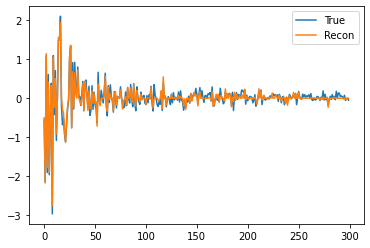

In [13]:

plt.figure(facecolor='w');
plt.plot(Obj.prop['true_coef'], label = 'True');
plt.plot(Obj.prop['recon_coef'][-1], label = 'Recon');
plt.legend();
plt.show();

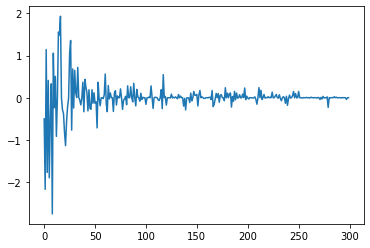

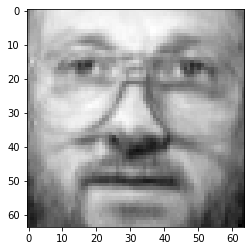

In [14]:
## forget smaller values
sparse_coef = np.array(Obj.prop['recon_coef'][-1]);
max_val = np.max(np.abs(sparse_coef));
#sparse_coef[np.where(np.abs(sparse_coef) < 1e-2* max_val)] = 0;
sparse_coef[1000:] = 0;

sparse_img = (psi.dot(sparse_coef) + X_train_mean.reshape(-1,1)).reshape(r,c);

plt.figure(facecolor='w');
plt.plot(sparse_coef);
plt.show();

plt.figure(facecolor='w');
plt.imshow(sparse_img, cmap = 'gray');
plt.show();

In [15]:
## Linear classifier
from sklearn import linear_model;
from sklearn.multiclass import OutputCodeClassifier;
from sklearn.svm import LinearSVC;


reg = OutputCodeClassifier(LinearSVC(random_state=0),code_size=2, random_state=0);

reg.fit((X_train - X_train_mean).dot(psi), y_train);
predictions = reg.predict(Obj.prop['recon_coef'][-1].T);
print(predictions)
print(np.sum(np.array(y_select) == np.round(predictions)));

[13]
1
